# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

## Structure data as needed

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

print(x_train.shape)
print(x_train.max())
print(x_test.shape)
print(x_test.max())

(60000, 28, 28, 1)
1.0
(10000, 28, 28, 1)
1.0


# Autoencoder

### Parameters

In [4]:
latent_dim = 10
hidden_dim = 64
batch_size = 16
epochs = 15
learning_rate = 0.0001

factor = 0.1
patience = 1
min_lr = 0.00001
verbose = 1

In [5]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor,
                              patience=patience, min_lr=min_lr, verbose=verbose)

### Encoder

In [6]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(hidden_dim/2, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(hidden_dim, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

### Sampling function

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Reparameterization
essential part of a variational autoencoder

In [8]:
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

### Decoder

In [9]:
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * hidden_dim, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, hidden_dim))(x)
x = layers.Conv2DTranspose(hidden_dim, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(hidden_dim/2, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

### VAE Model

In [10]:
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = keras.Model(decoder_inputs, decoder_outputs, name='decoder')

vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, vae_outputs, name='vae')

### Loss function

In [11]:
xent_loss = keras.losses.binary_crossentropy(encoder_inputs, vae_outputs)
xent_loss = K.sum(xent_loss, axis=[1, 2])  # Sum over all dimensions
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

### Compile

In [12]:
vae.add_loss(vae_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='binary_crossentropy')

# Training

In [13]:
fitting_output = vae.fit(x_train, x_train, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data=(x_test, x_test), 
                         callbacks=[reduce_lr])

Epoch 1/15
3750/3750 [==============================] - 70s 18ms/step - loss: 167.4690 - val_loss: 124.2686 - lr: 1.0000e-04
Epoch 2/15
3750/3750 [==============================] - 69s 18ms/step - loss: 120.5015 - val_loss: 116.0758 - lr: 1.0000e-04
Epoch 3/15
3750/3750 [==============================] - 70s 19ms/step - loss: 115.3005 - val_loss: 112.7913 - lr: 1.0000e-04
Epoch 4/15
3750/3750 [==============================] - 69s 19ms/step - loss: 112.6945 - val_loss: 110.8228 - lr: 1.0000e-04
Epoch 5/15
3750/3750 [==============================] - 71s 19ms/step - loss: 111.0677 - val_loss: 109.5697 - lr: 1.0000e-04
Epoch 6/15
3750/3750 [==============================] - 68s 18ms/step - loss: 109.8895 - val_loss: 108.7488 - lr: 1.0000e-04
Epoch 7/15
3750/3750 [==============================] - 70s 19ms/step - loss: 108.9568 - val_loss: 108.0262 - lr: 1.0000e-04
Epoch 8/15
3750/3750 [==============================] - 73s 20ms/step - loss: 108.2471 - val_loss: 107.3710 - lr: 1.0000e-04


In [14]:
training_history = fitting_output.history

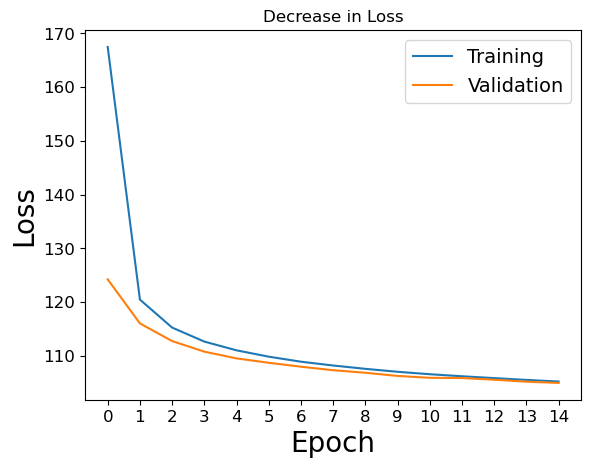

In [15]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['loss'], label='Training')
ax.plot(fitting_output.history['val_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_xticks(np.arange(0, epochs, 1))
plt.show()

# Testing

In [16]:
# use the test set
predictions = vae.predict(x_test)
print(predictions.shape)

313/313 [==============================] - 2s 6ms/step
(10000, 28, 28, 1)


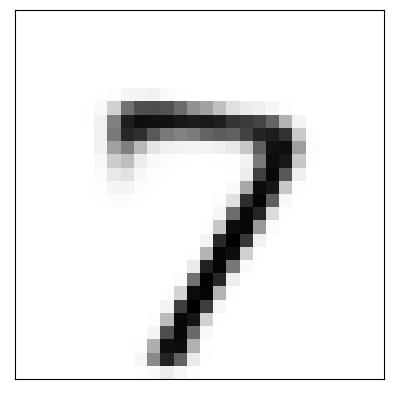

In [24]:
i = 0
fig, ax=plt.subplots()
ax.imshow(predictions[i], cmap=plt.cm.binary)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

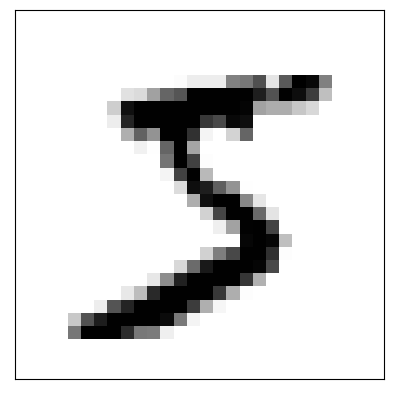

<function matplotlib.pyplot.show(close=None, block=None)>

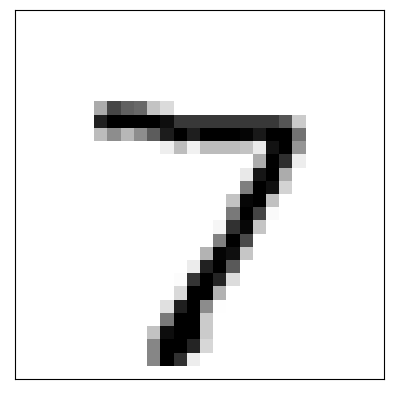

In [17]:
i = 0
fig, ax=plt.subplots()
ax.imshow(x_train[i], cmap=plt.cm.binary)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

fig, ax=plt.subplots()
ax.imshow(x_test[i], cmap=plt.cm.binary)
ax.set_xticks([])
ax.set_yticks([])
plt.show

# Generating new images

In [18]:
num_samples = 10
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
decoded_images = decoder.predict(random_latent_vectors)

1/1 [==============================] - 0s 84ms/step


### Displaying the generated images

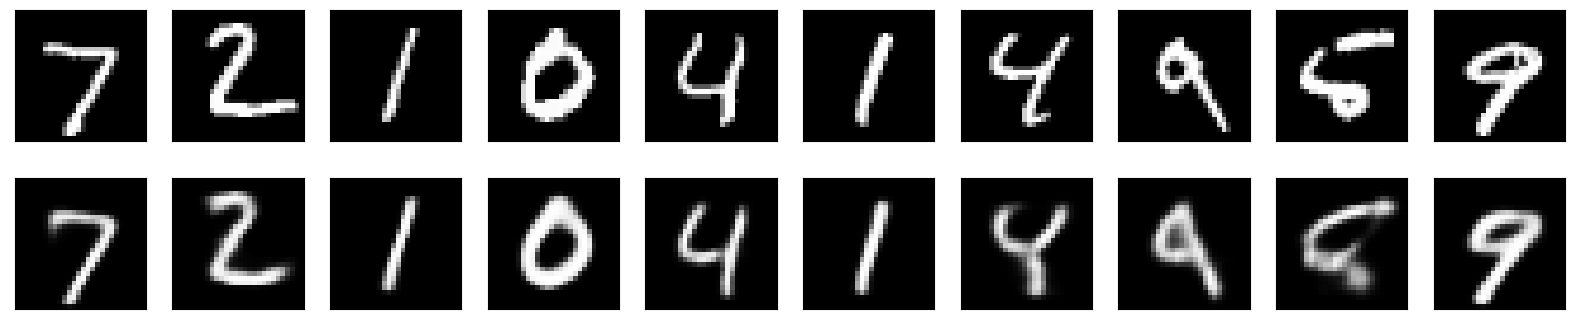

In [26]:
n = 10 
fig = plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('vae_MNIST')

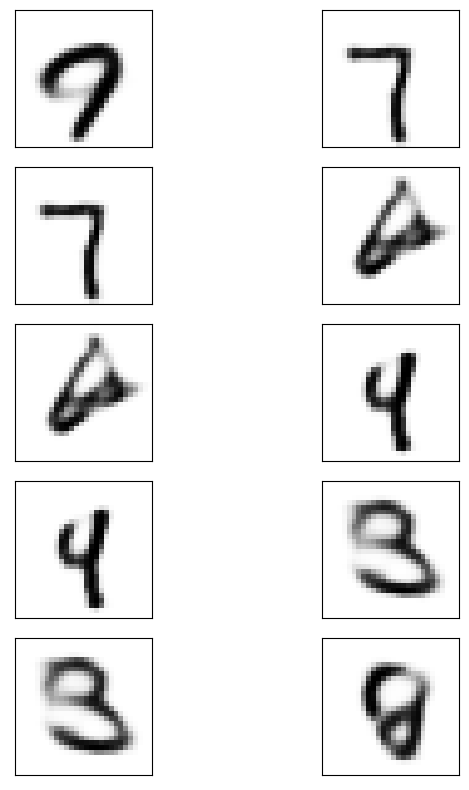

In [20]:
fig, ax=plt.subplots(5, 2, figsize = (8, 8))

for i in range(5):
    for j in range(2):
        ax[i,j].imshow(decoded_images[1*i+j], cmap=plt.cm.binary)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
plt.tight_layout()
plt.show()
